In [1]:
%matplotlib inline
import requests
from random import randint,random
import json
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data


/home/clive/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

def download_mnist():
    return input_data.read_data_sets("MNIST_data/", one_hot = True)

def rest_predict_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/predict",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_input_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-input",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_output_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-output",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def gen_mnist_data(mnist):
    batch_xs, batch_ys = mnist.train.next_batch(1)
    chosen=0
    gen_image(batch_xs[chosen]).show()
    data = batch_xs[chosen].reshape((1,784))
    return data


In [4]:
mnist = download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [5]:
!s2i build -E ./s2i/mnist_transformer/environment . seldonio/seldon-core-s2i-python3:0.2 mnist-caffe2-transformer:0.1

---> Installing application source...
Build completed successfully


In [9]:
!s2i build -E ./s2i/tensorrt-proxy/environment . seldonio/seldon-core-s2i-python3-tensorrt:0.1 tensorrt-proxy:0.1

---> Installing application source...
Build completed successfully


In [6]:
!docker run --name "mnist_transformer" -d --rm -p 5000:5000 mnist-caffe2-transformer:0.1

d8c03c9fcc3a789c3a338ffffd13695a6a6a9cb1d7517c04630c92f3f7a88288


In [10]:
!docker run --name "tensorrt-proxy" -it --rm -p 5001:5001 \
    -e PREDICTIVE_UNIT_SERVICE_PORT=5001 \
    -e PREDICTIVE_UNIT_PARAMETERS='[{"name":"url","type":"STRING","value":"35.204.122.195:8000"},{"name":"model_name","type":"STRING","value":"plan_mnist"},{"name":"protocol","type":"STRING","value":"HTTP"}]' \
    tensorrt-proxy:0.1

815b93c449bb1c256770801aea39f2175d817873006f40881d60362c8ea24af9


In [11]:
TRANSFORMER_URL="localhost:5000"
PREDICTOR_URL="localhost:5001"

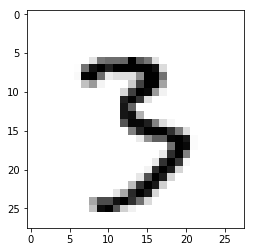

(1, 28, 28)


In [12]:
data = gen_mnist_data(mnist)
response = rest_transform_input_request(TRANSFORMER_URL,data)
transformed = np.array(response['data']['ndarray'])
print(transformed.shape)

In [14]:
response = rest_predict_request(PREDICTOR_URL,transformed)
predictions = np.array(response["data"]["ndarray"])
print(predictions)

[[[[3.12940490e-14]]

  [[3.18852019e-12]]

  [[3.53772719e-12]]

  [[1.00000000e+00]]

  [[1.97148629e-14]]

  [[2.33638597e-09]]

  [[9.59049666e-15]]

  [[4.99019714e-11]]

  [[1.49926880e-08]]

  [[7.07160663e-10]]]]


In [15]:
response = rest_transform_output_request(TRANSFORMER_URL,predictions)
print(response)

{'data': {'names': None, 'ndarray': [[3.1294048976520175e-14, 3.188520194402633e-12, 3.5377271858511028e-12, 1.0, 1.9714862947999186e-14, 2.3363859735781034e-09, 9.590496663968925e-15, 4.990197144394415e-11, 1.4992687979997754e-08, 7.071606633601846e-10]]}}
